<a href="https://colab.research.google.com/github/kevc528/MovieDatasetAnalysis/blob/master/KevinChen_MoviesNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS545 Final Project: Analyzing Movie Data
## Kevin Chen


![alt text](https://cdn.digg.com/wp-content/uploads/2020/01/16124337/Screen-Shot-2020-01-16-at-11.42.56-AM.png)


In this project I will be exploring The Movies Dataset, which is found on Kaggle at https://www.kaggle.com/rounakbanik/the-movies-dataset/data#credits.csv. In this project I will be exploring data on thousands of movies. Everyone likes movies, so why not learn more from the vast amount of data we have? Specifically, I will be exploring data about movies themselves, and also data about how viewers rate movies. After exploring the data, I will move in to the modeling portion of this project. The modeling will focus on a creating a simple movie recommendation system. Recommendation systems are widely used today and very important for so many companies, making them a very popular application of data science!

## Setup

To set up the data, I relied a lot on Kaggle's API access. I created an API key and saved a downloadable json file into a folder in my drive named "Kaggle"

In [73]:
# Need a folder in google drive called "Kaggle", containing "kaggle.json", a 
# file that is created after obtaining Kaggle API access
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle

!kaggle datasets download -d rounakbanik/the-movies-dataset

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/gdrive
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-8b3d87852aca>", line 7, in <module>
    get_ipython().magic('cd /content/gdrive/My Drive/Kaggle')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connec

OSError: ignored

In [2]:
!unzip \*.zip  && rm *.zip

Archive:  the-movies-dataset.zip
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [3]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26819 sha256=b28bee19b4b2fbc6ee93f15b7d937c16dd44bab7298c0184f573dc09905925b0
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandasql as ps
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Movie Dataset Analysis

Let's first start by looking at some information about movies. First let's import the data and set all the types to their intended types. Note that we've filtered out movies with less than or equal to 20 votes because then a single vote won't have as much weight and there is a more general consesus about the movie. We don't want a movie to be affected so much by just one single vote.

In [5]:
import json

movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)

# converting to the correct types
movies_df = movies_df[movies_df.budget.apply(lambda x: x.isnumeric())]
movies_df['vote_count'] = pd.to_numeric(movies_df['vote_count'])
movies_df['budget'] = pd.to_numeric(movies_df['budget'])

movies_df = movies_df[(movies_df['budget'] > 0) & (movies_df['vote_count'] > 20)]

movies_df['adult'] = movies_df['adult'].astype('bool')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'])
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'])
movies_df['runtime'] = pd.to_numeric(movies_df['runtime'])
movies_df['vote_average'] = pd.to_numeric(movies_df['vote_average'])

movies_df = movies_df.replace({'\'': '"'}, regex=True)

movies_df = movies_df.reset_index()

movies_df.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,True,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0
1,1,True,NaN,65000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,262797249.0,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,3,True,NaN,16000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,81452156.0,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
3,5,True,NaN,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,187436818.0,170.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
4,6,True,NaN,58000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1995-12-15,0.0,127.0,"[{""iso_639_1"": ""fr"", ""name"": ""Français""}, {""is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0


Now let's look at some of the highest rated movies. We do this using a SQL query to order by the average vote rating for a movie. Do you see any movies that you like?

In [6]:
sqldf = lambda x : ps.sqldf(x, globals())

q = '''
    SELECT title, vote_average, vote_count
    FROM movies_df
    ORDER BY vote_average DESC
    LIMIT 40
    '''

top_rated_df = sqldf(q)
top_rated_df

,title,vote_average,vote_count
0,Dilwale Dulhania Le Jayenge,9.1,661.0
1,Stop Making Sense,8.7,47.0
2,Human,8.6,98.0
3,The Shawshank Redemption,8.5,8358.0
4,The Godfather,8.5,6024.0
5,Parched,8.5,23.0
6,Pulp Fiction,8.3,8670.0
7,"Schindler""s List",8.3,4436.0
8,"One Flew Over the Cuckoo""s Nest",8.3,3001.0
9,Psycho,8.3,2405.0


Similarly, we can view the movies with the lowest ratings. Any surprises?

In [7]:
q = '''
    SELECT title, vote_average, vote_count
    FROM movies_df
    ORDER BY vote_average ASC
    LIMIT 40
    '''

low_rated_df = sqldf(q)
low_rated_df

,title,vote_average,vote_count
0,Manos: The Hands of Fate,2.0,56.0
1,Foodfight!,2.3,28.0
2,2012 Doomsday,2.3,32.0
3,Pledge This!,2.7,34.0
4,House of the Dead,2.8,106.0
5,Quantum Apocalypse,2.8,25.0
6,Dragonball Evolution,2.9,475.0
7,Ace Ventura Jr: Pet Detective,2.9,41.0
8,500 MPH Storm,2.9,21.0
9,Battlefield Earth,3.0,259.0


From our analysis above, we notice that the vote average ratings range from 2.0 to 9.1. 

Now let's look into more information about all of these movies and try to learn more about the movie industry.

In [8]:
movie_average = movies_df['vote_average'].mean()
movie_average

6.248124152478539

Above, we found that the average rating of a movie was around 6.25. Was this what you expected?

Now we are moving on to charting the distribution of average ratings for each movie. To make the chart simpler, we will first round all of the ratings to the nearest whole number. Then we will display a table of frequencies for each whole integer rating and display these in a chart.

In [9]:
rounded_ratings_df = movies_df[['title', 'vote_average']]
rounded_ratings_df['vote_average'] = rounded_ratings_df['vote_average'].apply(
                                            lambda x: round(x, 0)
                                          )
rounded_ratings_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,title,vote_average
0,Toy Story,8.0
1,Jumanji,7.0
2,Waiting to Exhale,6.0
3,Heat,8.0
4,Sabrina,6.0
...,...,...
6632,Wind River,7.0
6633,Detroit,7.0
6634,Sivaji: The Boss,7.0
6635,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",5.0


In [10]:
q = '''
    SELECT vote_average, COUNT(*) AS count
    FROM rounded_ratings_df
    WHERE vote_average IS NOT NULL
    GROUP BY vote_average
    '''

grouped_ratings_df = sqldf(q)
grouped_ratings_df

,vote_average,count
0,2.0,3
1,3.0,26
2,4.0,237
3,5.0,939
4,6.0,2835
5,7.0,2067
6,8.0,527
7,9.0,3


Text(0, 0.5, 'Count')

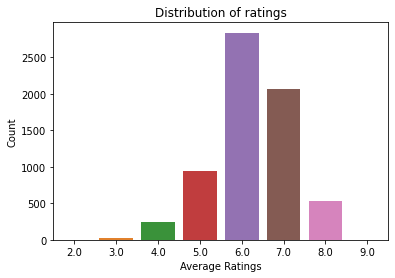

In [11]:
plt = sns.barplot(grouped_ratings_df['vote_average'], grouped_ratings_df['count'])
plt.set_title('Distribution of ratings')
plt.set_xlabel('Average Ratings')
plt.set_ylabel('Count')

Above, we see that the distribution for average ratings for each movie is roughly normal with a peak at a rating close to 6.0. However, we can see from this graph that there is a tendency for movies to recieve slightly higher ratings compared to lower ratings.

#### Genre Analysis

Now that we know a bit of info on how the movies are rated, let's explore more about the details of these movies. Let's start by investigating some genres of these movies and look for the most popular genres for movies.

First we must notice that our original dataframe stored genres as a list of json objects within a column. We have to parse this json, and make multiple rows for each movie if it is part of multiple genres. This way, every genre can be accounted for given movies are able to share multiple genres.

In [12]:
import ast

df1 = (pd.concat({k: pd.DataFrame(json.loads(v)) for k, v in movies_df['genres'].items()})
         .reset_index(level=1, drop=True))

# new table useful because # of genres won't overscale anything else
movies_df_genres = movies_df.join(df1, rsuffix='_genre').reset_index(drop=True)
movies_df_genres.rename(columns={"name": "genre_name"}, inplace=True)
movies_df_genres.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,id_genre,genre_name
0,0,True,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0,16.0,Animation
1,0,True,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0,35.0,Comedy
2,0,True,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0,10751.0,Family
3,1,True,NaN,65000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,262797249.0,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,12.0,Adventure
4,1,True,NaN,65000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,262797249.0,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,14.0,Fantasy


Now that we have successfully "expanded" the column containing the json list for genres, we now prepare to display the information about genres. For the purpose of displaying this information, we will use a pie chart. This is good for visualizing the proportion of a genre within the industry. To prepare for creating a pie chart, we must gather all of the frequencies for each genre. We will store this in a dictionary. Additioanlly, we'll store any genre with fewer than 200 movies as part of a category called 'Other'.

In [0]:
import json

genres = {}

for genre in movies_df_genres['genre_name']:
  if genre in genres:
    genres[genre] += 1
  else:
    genres[genre] = 1

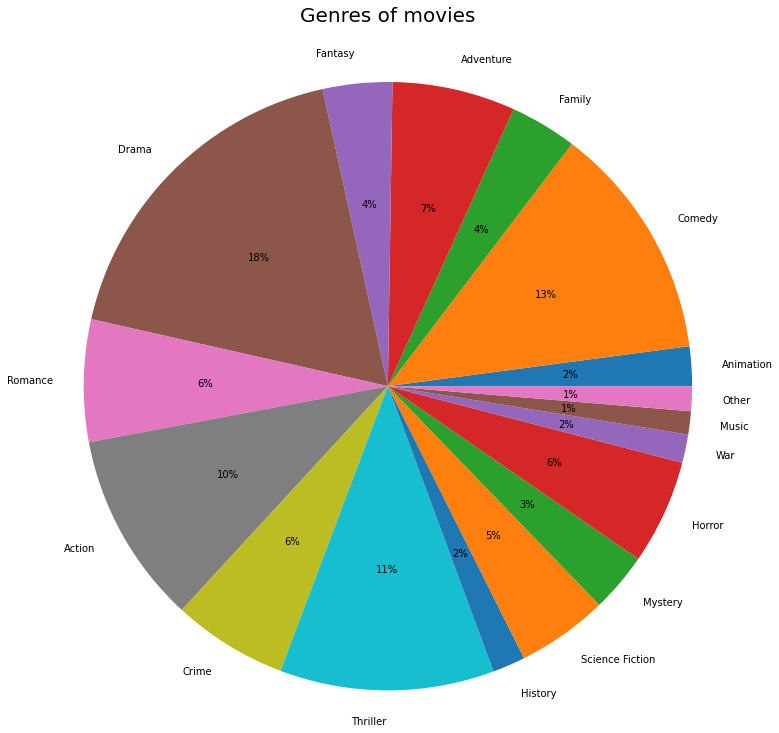

In [14]:
import matplotlib.pyplot as plt

genres['Other'] = 0
to_del = []

for g in genres:
  if g != 'Other':
    if genres[g] < 200:
      genres['Other'] += genres[g]
      to_del.append(g)

for d in to_del:
  del genres[d]

sizes = [genres[x] for x in genres]
labels=[x for x in genres]

try:
  fig1, ax1 = plt.subplots()
  fig1.set_size_inches(12, 12)
  patches, text = ax1.pie(sizes, labels=labels, autopct='%.0f%%')
except:
  pass

ax1.axis('equal')
ax1.set_title("Genres of movies", fontsize = 20)
ax1.title.set_position([.5, 1.05])
plt.show()

Based on our results above, we see that the most common genre is Drama, followed by Comedy, Trhiller, and Action. Knowing these frequencies could be important when determine factors to consider when modeling.

It is a common conception that movies with a higher budget are rated higher. Let's investigate this claim by comparing the vote rating average for movies based on their budgets.

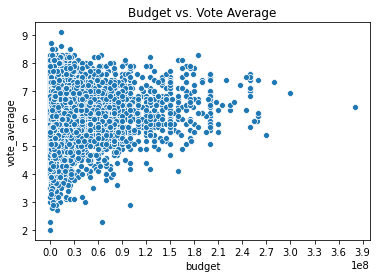

In [15]:
import matplotlib.ticker as ticker

ax = sns.scatterplot(movies_df['budget'], movies_df['vote_average'])
ax.xaxis.set_major_formatter(ax.get_xaxis().get_major_formatter())
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=30000000))
ax.set_title('Budget vs. Vote Average')
ax.set_xlabel
plt.show()

The graph produced above is very interesting. It seems like as the budget gets higher and higher, the variation among ratings decreases. For lower budgets, a movie can either be very good or very bad, but as the budget increases, the ratings start to consilidate in the 5-8 rating range. So budget might not make your movie a 10/10, but it could be important for being confident that your movie isn't a total flop.

Now let's investigate movie revenue. Specifically, we are looking at whether a higher rating constitutes more revenue generated from a movie. Do better movies generate more revenue?

Text(0.5, 1.0, 'Vote Average vs. Revenue')

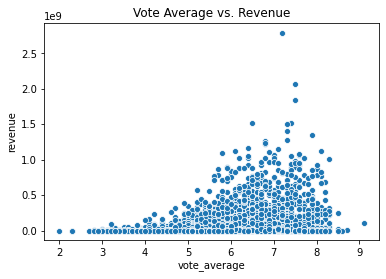

In [16]:
ax = sns.scatterplot(movies_df['vote_average'], movies_df['revenue'])
ax.set_title('Vote Average vs. Revenue')

The graph above is really interesting. The main idea is that lower rated movies almost never make a good amount of revenue, and as the rating increases, there are more movies that make more revenue, but there continues to be many movies that make little amounts of revenue. From here we learn that there are many factors that go into revenue for a movie, not just how highly rated and successful it is.

The next thing we are investigating is how the movie industry is changing throughout time. I wanted to see how many more movies were made today compared to decades ago. Here we will be plotting the count of movies made every 15 or so years throughout the past 80 years.

Text(0, 0.5, 'Count')

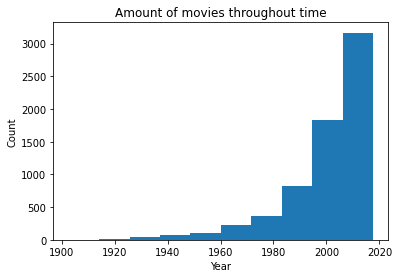

In [17]:
ax = plt.hist(movies_df['release_date'])
plt.title('Amount of movies throughout time')
plt.xlabel('Year')
plt.ylabel('Count')

This was what we expected. As technology became more and more advanced, more and more movies could be created, leading to a huge increase of movie production over the years.

#### User Ratings Analysis.

We've learned a lot about movies and now let's transition into learning information about the users who rate these movies by analyzing the ratings.csv data. Note that the system for ratings in this table is on a 5 star scale, but in the movies data frame the rating is based on a 0 to 10 scale.

In [18]:
ratings_df = pd.read_csv('ratings.csv', low_memory=False)
ratings_df

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


We want to gain information about users, so we will group by userId so we can get a general idea about the behaviors of each user.

In [19]:
q = '''
SELECT userId, COUNT(*) as count, AVG(rating) as average
FROM ratings_df
GROUP BY userId
'''

user_ratings_df = sqldf(q)
user_ratings_df

,userId,count,average
0,1,27,4.277778
1,2,22,3.318182
2,3,10,3.100000
3,4,62,3.500000
4,5,26,4.269231
...,...,...,...
270891,270892,75,3.640000
270892,270893,190,3.673684
270893,270894,148,2.516892
270894,270895,20,4.300000


Now that we've finished setting up, let's learn more about the behaviors of users. First let's find the typical amount of movies that each user rates.

In [0]:
q = '''
SELECT * FROM user_ratings_df
ORDER BY count DECR
'''

user_ratings_df = sqldf(q)
user_ratings_df

Text(0.5, 1.0, 'Distribution for reviews per user')

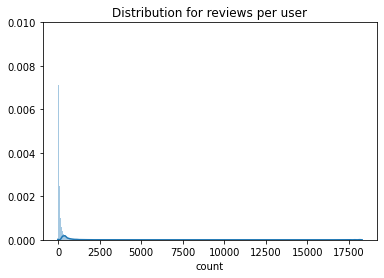

In [57]:
plt = sns.distplot(user_ratings_df['count'], bins=800)
# plt.set(xlim=(0,800))
plt.set(ylim=(0,0.01))
plt.set_title('Distribution for reviews per user')

In [49]:
rating_count_average = user_ratings_df['count'].mean()
rating_count_average

96.06745393065974

In [51]:
rating_count_med = user_ratings_df['count'].median()
rating_count_med

30.0

Text(0.5, 1.0, 'Distribution for reviews per user')

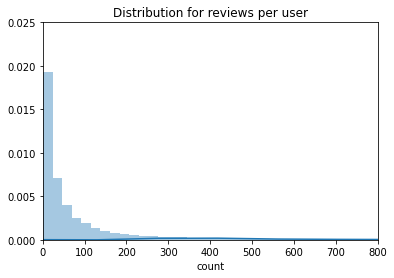

In [64]:
plt = sns.distplot(user_ratings_df['count'], bins=800)
plt.set(xlim=(0,800))
plt.set(ylim=(0,0.025))
plt.set_title('Distribution for reviews per user')

Here our analysis indicates that the amount of ratings users submit are usually under 100, around 30. However, there are a few users who submit many many reviews, which causes the average to be so much higher than the median.

Now let's learn about the distribution of average ratings for each user. Here we can see if users are generally more positive with their ratings or more negative.

Text(0.5, 1.0, 'Distribution for average ratings per user')

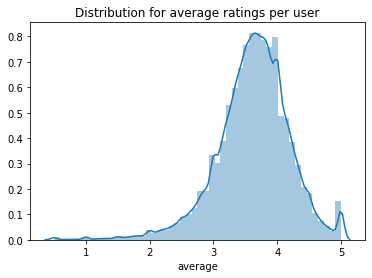

In [54]:
plt = sns.distplot(user_ratings_df['average'], bins=50)
plt.set_title('Distribution for average ratings per user')

In [65]:
user_rating_average = user_ratings_df['average'].mean()
user_rating_average

3.6205382062299956

In [71]:
q = '''
SELECT * FROM user_ratings_df
WHERE count >= 5
ORDER BY average DESC
'''

positive_users_df = sqldf(q)
positive_users_df

,userId,count,average
0,57,15,5.0
1,315,15,5.0
2,464,17,5.0
3,550,15,5.0
4,980,8,5.0
...,...,...,...
256102,236749,15,0.5
256103,239335,16,0.5
256104,240352,9,0.5
256105,245398,20,0.5


Having observed this distribution, there are definitely some very positive users and some very negative users. But in general, most users give around a 3.6 rating, making the distribution of ratings pretty close to normal with the peak at 3.6. Knowing this, the users in general are pretty nice.

#### Prepping data for Machine Learning

#### Model 1: K Nearest Neighbors

The purpose of this model is to find similar movies to a movie that a user has enjoyed. By using K nearest neighbors, I can find the nearest neighbors to the movie that the user enjoyed and output these movies as similar. This model works because, in theory, the closer two movies are in dimensional space, the more similar in characterisitcs these two movies are.

First we will dive into creating clusters for movies and recommending based on this. To set up, we drop columns, merge any features we want and also create one-hot encodings for the categorical variables that shouldn't be treated numerically, like genre. 

Additionally, I thought the including a little bit of data from the production of the movie could be useful for recommendations. Because of this, I included features like production company, and also director (obtained from the credits.csv data). 

In [0]:
credits_df = pd.read_csv('credits.csv', low_memory=False, index_col = 'id')
credits_df = credits_df.replace({'\'': '"'}, regex=True)
credits_df.head()

In [0]:
clustering_df = movies_df.copy(deep = True)

clustering_df['drama'] = clustering_df['genres'].apply(lambda x : 1 if 'Drama' in x else 0)
clustering_df['comedy'] = clustering_df['genres'].apply(lambda x : 1 if 'Comedy' in x else 0)
clustering_df['thriller'] = clustering_df['genres'].apply(lambda x : 1 if 'Thriller' in x else 0)
clustering_df['action'] = clustering_df['genres'].apply(lambda x : 1 if 'Action' in x else 0)
clustering_df['adventure'] = clustering_df['genres'].apply(lambda x : 1 if 'Adventure' in x else 0)

def company(x):
    try:
        return json.loads(x)[0]['id']
    except:
        return -1

clustering_df['production_companies'] = clustering_df['production_companies'].apply(company)

clustering_df = clustering_df.drop(columns=['homepage', 'genres', 'imdb_id', 'original_language', 'original_title', 
                            'overview', 'poster_path', 'status', 'tagline', 'title', 'video', 'belongs_to_collection',
                            'production_countries', 'spoken_languages','release_date'
                            ])
clustering_df = pd.get_dummies(clustering_df, prefix = ['production_companies'], columns=['production_companies'])
clustering_df.head()

,index,adult,budget,id,popularity,revenue,runtime,vote_average,vote_count,drama,comedy,thriller,action,adventure,production_companies_-1,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_23,production_companies_24,production_companies_25,production_companies_27,production_companies_28,production_companies_29,production_companies_32,production_companies_33,...,production_companies_68257,production_companies_68384,production_companies_68620,production_companies_68860,production_companies_69112,production_companies_69791,production_companies_72023,production_companies_72184,production_companies_72926,production_companies_73436,production_companies_73571,production_companies_74116,production_companies_74361,production_companies_74807,production_companies_74910,production_companies_75277,production_companies_76460,production_companies_76634,production_companies_77019,production_companies_77471,production_companies_77970,production_companies_78370,production_companies_78688,production_companies_79986,production_companies_80514,production_companies_81142,production_companies_81175,production_companies_81254,production_companies_84797,production_companies_84803,production_companies_85028,production_companies_85627,production_companies_85869,production_companies_86256,production_companies_87426,production_companies_89312,production_companies_91244,production_companies_91689,production_companies_93065,production_companies_93224
0,0,True,30000000,862,21.946943,373554033.0,81.0,7.7,5415.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,True,65000000,8844,17.015539,262797249.0,104.0,6.9,2413.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,True,16000000,31357,3.859495,81452156.0,127.0,6.1,34.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,True,60000000,949,17.924927,187436818.0,170.0,7.7,1886.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,True,58000000,11860,6.677277,0.0,127.0,6.2,141.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
q = '''
SELECT clustering_df.*, credits_df.crew
FROM clustering_df, credits_df
WHERE clustering_df.id = credits_df.id
'''

clustering_df = sqldf(q)

In [0]:
def director(x):
  x = x.split('},')
  for chunk in x:
    if 'Director' in chunk:
      group = chunk.split(',')
      for g in group:
        if '"id"' in g:
          index = g.find('id: ')
          return(g[index+8:])

clustering_df['director'] = clustering_df['crew'].apply(director)

In [0]:
clustering_df = clustering_df.drop(columns=['crew', 'id'])
clustering_df = pd.get_dummies(clustering_df, prefix = ['director'], columns=['director'])
clustering_df.head()

,index,adult,budget,popularity,revenue,runtime,vote_average,vote_count,drama,comedy,thriller,action,adventure,production_companies_-1,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_15,production_companies_16,production_companies_17,production_companies_18,production_companies_23,production_companies_24,production_companies_25,production_companies_27,production_companies_28,production_companies_29,production_companies_32,production_companies_33,production_companies_34,...,director_96691,director_967417,director_967767,director_967792,director_96813,director_96854,director_970129,director_97026,director_97131,director_97296,director_974,director_97555,director_97618,director_97710,director_97755,director_9789,director_97966,director_98132,director_9819,director_9820,director_9822,director_983909,director_98534,director_9855,director_98631,director_9867,director_9868,director_98750,director_9894,director_989512,director_9915,director_991868,director_99313,director_995407,director_995462,director_9965,director_997,director_998507,director_99916,director_999760
0,0,1,30000000,21.946943,373554033.0,81.0,7.7,5415.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,65000000,17.015539,262797249.0,104.0,6.9,2413.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,16000000,3.859495,81452156.0,127.0,6.1,34.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,1,60000000,17.924927,187436818.0,170.0,7.7,1886.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,1,58000000,6.677277,0.0,127.0,6.2,141.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now I use Principal component analysis (PCA) to reduce number of dimensions of the dataset. To do this, I first fit a pca model on my data and then plotted the explained_variance_ratio against the number of components to decide the number of components I should keep. PCA was extremely important because I had over 5000 columns due to all of the one hot encodings

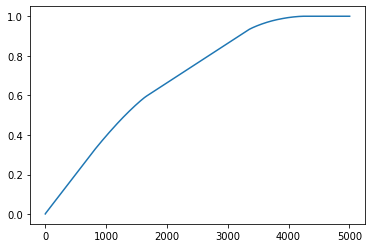

In [0]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustering_df = StandardScaler().fit_transform(clustering_df.dropna())

pca = PCA(n_components= 5006)
pca.fit(clustering_df)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)
plt.show()

From the graph above, I decided around 3300 components is around ideal. So I fit and transformed my data using PCA, and built a K nearest neighbors model using scikit learn. I used k=10 because I just wanted to output 10 recommendations.

In [0]:
pca = PCA(n_components= 3300)
pca.fit(clustering_df)
clustering_df = pca.fit_transform(clustering_df)

In [0]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='cosine', n_neighbors=10)
model.fit(clustering_df)
distances, indices = model.kneighbors(clustering_df)

After creating and fitting the model, I can now have access to the k nearest neighbors for each movie, making it simple to take in a movie name and output the k nearest neighbors.

In [0]:
def recommend():
  title = input('Enter movie title: ')

  try:
    movie_id = int(movies_df[movies_df["title"]==title].index.tolist()[0])
    print('Recommendations:')
    for id in indices[movie_id][1:]:
      try:
        print(movies_df.iloc[id]["title"])
      except:
        continue
  except:
    print('No movie found')

Below are a few runs of the recommendation algorithm. It takes in an input from the user which will be the movie title. Then it will produce 10 recommendations. Overall, the recommendations are ok. There is a good mix of accurate recommendations and inaccurate recommendations. This is because our data probably doesn't have enough impactful features to distinguish movies apart. Overall, the recommendations are still pretty useful and better than just randomly recommending movies.

In [0]:
recommend()

Enter movie title: Beauty and the Beast
Recommendations:
The Hunchback of Notre Dame
Dr. Dolittle 2
The Reader
Next Time I"ll Aim for the Heart
Lara Croft Tomb Raider: The Cradle of Life
Joy Ride 2: Dead Ahead
The Three Musketeers
Marie Antoinette
The Double Hour


In [0]:
recommend()

Enter movie title: Harry Potter and the Half-Blood Prince
Recommendations:
Oz: The Great and Powerful
Osama
Romeo + Juliet
Mighty Aphrodite
Nutty Professor II: The Klumps
Love and Death
A Fish Called Wanda
Edward Scissorhands
The Rules of the Game


In [0]:
recommend()

Enter movie title: Jumanji
Recommendations:
The Spy Next Door
The Pagemaster
Sleeping Beauty
Ghost World
The Girl Next Door
Manhattan Murder Mystery
Bulworth
The Fan
Fatal Attraction


#### Now we have a recommendation system that determines similar movies to a movie someone liked. We will now build a recommendation system for finding new movies based on a user who rated other movies